#  High Value Customer Identification

#  0.0 Imports 

In [64]:
import pandas   as pd
import numpy    as np
import seaborn  as sns
import inflection
import re
import s3fs
import os
from tabulate             import tabulate

from   datetime           import datetime
from   sqlalchemy         import create_engine
import sqlite3

from matplotlib           import pyplot   as plt
from matplotlib           import cm
from plotly               import express  as px

import umap.umap_         as umap
from yellowbrick.cluster  import KElbowVisualizer, SilhouetteVisualizer
from sklearn              import cluster       as c
from sklearn              import metrics       as m
from sklearn              import preprocessing as pp
from sklearn              import decomposition as dd
from sklearn              import manifold      as mf
from sklearn              import ensemble      as en
from sklearn              import mixture       as mx
from scipy.cluster        import hierarchy     as hc
import pickle

import warnings

#  0.1 Helper Functions

In [2]:
def pickle_dump (model,folder,variable):
    return pickle.dump( model, open( '../src/'+ folder +'/'+ variable +'.pkl', 'wb') )

AWS_ACCESS_KEY_ID = os.environ.get( 'AWS_ACCES_KEY_ID_CDS')
AWS_SECRET_ACCESS_KEY = os.environ.get( 'AWS_SECRET_ACCESS_KEY_CDS')

warnings.filterwarnings("ignore")

sns.set()

# 0.2 Load dataset

In [3]:
# read data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')
df_raw = df_raw.drop('Unnamed: 8', axis=1).copy()

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Data description 

In [5]:
df1 = df_raw.copy()

## <font color='black'> 1.1 Rename columns </font>

In [6]:
# columns names
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerId', 'Country']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

# renaming columns name
df1.columns = cols_new

### <font color='black'>  Feature Description </font>

In [7]:
# Feature meanings
tab_meanings = [['Columns', 'Meaning'],
        ['invoice_no', 'unique identifier of each transaction'],
        ['stock_code', 'item code'],
        ['description', 'item name'],
        ['quantity', 'quantity of each item purchased per transaction'],
        ['invoice_date', 'the day the transaction took place'],
        ['unit_price', 'product price per unit'],
        ['customer_id', 'unique customer identifier'],
        ['country', 'customer\'s country of residence']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='simple'))

Columns       Meaning
------------  -----------------------------------------------
invoice_no    unique identifier of each transaction
stock_code    item code
description   item name
quantity      quantity of each item purchased per transaction
invoice_date  the day the transaction took place
unit_price    product price per unit
customer_id   unique customer identifier
country       customer's country of residence


## <font color='black'> 1.2 Data dimensions </font>

In [8]:
print('Number of rows {}'.format(df1.shape[0]))
print('Number of columns {}'.format(df1.shape[1]))

Number of rows 541909
Number of columns 8


## <font color='black'> 1.3 Data types </font>

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## <font color='black'> 1.4 Check NA </font>

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## <font color='black'> 1.5 Replace NA </font>

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]


# check if we can fill customer NA by invoice correspondence
#missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()

#df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :]

# create a dummy customer id for each invoice number 
# create reference dataframe
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no' , how='left' )

# coalesce
df1 ['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'], axis=1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## <font color='black'> 1.6 Change types </font>

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

# invoice_no
#df1['invoice_no'] = df1['invoice_no'].astype(int)
#there are letters on invoice, so let it like object(string). Ex: 'C536379', 'C554197'

# stock_code
#df1['stock_code'] = df1['stock_code'].astype(int)
#there are letters on stock_code, so let it like object(string). Ex: '85123A', '84406B'

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


## <font color='black'> 1.7 Descriptive statistics  </font>

In [15]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])


### <font color='black'> 1.7.1 Numerical Attributes  </font>

In [16]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() -x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
st = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
st.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
st


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### <font color='black'> 1.7.2 Categorical Attributes  </font>

#### Invoice No

In [17]:
# The invoice_no has characters and numbers
#df1['invoice_no'].astype(int)

# identifying 
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),:]
df_letter_invoices.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548


In [18]:
# number of invoices that have at least a character in the invoice number and quantity are negative
print('Total number of invoices: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


#### <font color='black'> Stock Code </font>

In [19]:
# check stock codes - only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()


array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [20]:
# Actions:
# Remove stock_code in [POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']

# <font color=''> 2.0 Variables Filtering </font>

In [21]:
df2 = df1.copy()

In [22]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] >=0.04,:]

# stock code != ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns = 'description', axis=1)

# bad users
df2 = df2[~df2['customer_id'].isin( [16446])]

# quantity - Negative numbers means product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]



# <font color='black'> 3.0 Feature Engineering </font>

In [23]:
df3 = df2.copy()

## <font color='black'> 3.1 Feature creation  </font>

In [24]:
# data reference
df_ref = df3.drop(['invoice_no','stock_code','quantity','invoice_date','unit_price','country'],axis=1).drop_duplicates(ignore_index=True)


### <font color='black'> 3.1.1 Gross Revenue  </font>

In [25]:
# Gross Revenue
df2_purchase['gross_revenue'] = df2_purchase['quantity'] * df2_purchase['unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')


### <font color='black'> 3.1.2 Recency - Day from last purchase  </font>

In [26]:
# Recency - it depende on product returns
df_recency = df2_purchase[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### <font color='black'> 3.1.3 Quantity of purchases </font>

In [27]:
# Number of purchases
df_freq=df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qtde_invoices'})
df_ref = pd.merge(df_ref,df_freq, on='customer_id',how='left')

### <font color='black'> 3.1.4 Quantity of items purchased </font>

In [28]:
# Number of products
df_freq=df2_purchase[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_items'})
df_ref = pd.merge(df_ref,df_freq, on='customer_id',how='left')

### <font color='black'> 3.1.5 Quantity of products purchased </font>

In [29]:
# Number of products
df_freq=df2_purchase[['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qtde_products'})
df_ref = pd.merge(df_ref,df_freq, on='customer_id',how='left')

### <font color='black'> 3.1.6 Average Ticket Value  </font>

In [30]:
# Avg Ticket
df_avg_ticket = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')


### <font color='black'> 3.1.8 Frequency Purchase </font>

In [31]:
df_aux = (df2_purchase[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                 .groupby('customer_id')
                                                 .agg(max_=('invoice_date', 'max'), 
                                                      min_=('invoice_date', 'min'), 
                                                      days_=('invoice_date',lambda x: (x.max()-x.min()).days +1),
                                                      buy_=('invoice_no', 'count'))).reset_index()

# frequency
df_aux['frequency'] = df_aux[['buy_','days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
frequency        91
dtype: int64

### <font color='black'> 3.1.9 Number of Returns </font>

In [32]:
# Number of returns
df_returns = df2_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns']*(-1)

df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns']=0
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
frequency        91
qtde_returns      0
dtype: int64

In [33]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,17.000000,40.0
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,0.028302,35.0
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,0.040323,50.0
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,0.017921,0.0
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,0.073171,22.0


# <font color=''> 4.0 Exploratory Data Analysis </font>

In [34]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_invoices    0
qtde_items       0
qtde_products    0
avg_ticket       0
frequency        0
qtde_returns     0
dtype: int64

## <font color=''> 4.3 Space Study </font>

In [55]:
# select dataset
df43=df4.drop('customer_id', axis=1)


In [56]:
mm = pp.MinMaxScaler()
fs = s3fs.S3FileSystem( anon=False, key=AWS_ACESS_KEY_ID, secret=AWS_SECRET_ACCESS_KEY)

df43['gross_revenue']  = mm.fit_transform( df43[['gross_revenue']])
pickle_dump(mm,'features','gross_revenue')
# save to S3
pickle.dump( mm, fs.open( 's3://insiders-dataset/gross_revenue.pkl','wb' ), protocol = pickle.HIGHEST_PROTOCOL )

df43['recency_days']   = mm.fit_transform( df43[['recency_days']])
pickle_dump(mm,'features','recency_days')
# save to S3
pickle.dump( mm, fs.open( 's3://insiders-dataset/recency_days.pkl','wb' ), protocol = pickle.HIGHEST_PROTOCOL )

df43['qtde_invoices']  = mm.fit_transform( df43[['qtde_invoices']])
pickle_dump(mm,'features','qtde_invoices')
# save to S3
pickle.dump( mm, fs.open( 's3://insiders-dataset/qtde_invoices.pkl','wb' ), protocol = pickle.HIGHEST_PROTOCOL )

df43['qtde_items']     = mm.fit_transform( df43[['qtde_items']])
pickle_dump(mm,'features','qtde_items')
# save to S3
pickle.dump( mm, fs.open( 's3://insiders-dataset/qtde_items.pkl','wb' ), protocol = pickle.HIGHEST_PROTOCOL )

df43['qtde_products']  = mm.fit_transform( df43[['qtde_products']])
pickle_dump(mm,'features','qtde_products')
# save to S3
pickle.dump( mm, fs.open( 's3://insiders-dataset/qtde_products.pkl','wb' ), protocol = pickle.HIGHEST_PROTOCOL )

df43['avg_ticket']     = mm.fit_transform( df43[['avg_ticket']])
pickle_dump(mm,'features','avg_ticket')
# save to S3
pickle.dump( mm, fs.open( 's3://insiders-dataset/avg_ticket.pkl','wb' ), protocol = pickle.HIGHEST_PROTOCOL )

df43['frequency']      = mm.fit_transform( df43[['frequency']])
pickle_dump(mm,'features','frequency')
# save to S3
pickle.dump( mm, fs.open( 's3://insiders-dataset/frequency.pkl','wb' ), protocol = pickle.HIGHEST_PROTOCOL )

df43['qtde_returns']   = mm.fit_transform( df43[['qtde_returns']])
pickle_dump(mm,'features','qtde_returns')
# save to S3
pickle.dump( mm, fs.open( 's3://insiders-dataset/qtde_returns.pkl','wb' ), protocol = pickle.HIGHEST_PROTOCOL )

X = df43.copy()


### <font color=''> 4.3.1 PCA </font>

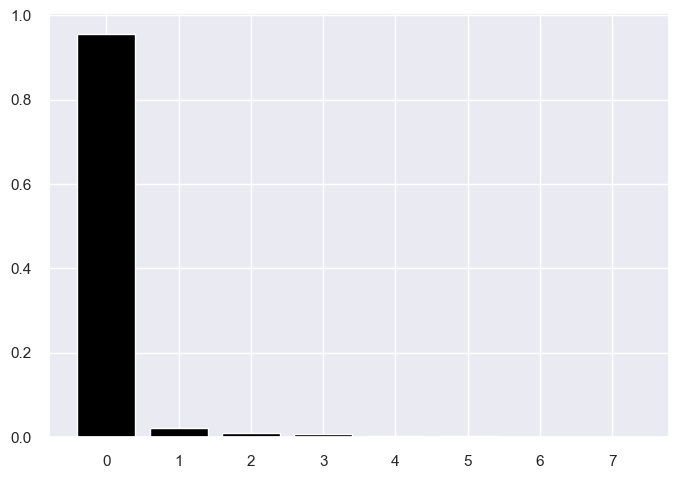

In [57]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_)

plt.bar( features, pca.explained_variance_ratio_, color= 'black');

# pca component
df_pca = pd.DataFrame( principal_components )


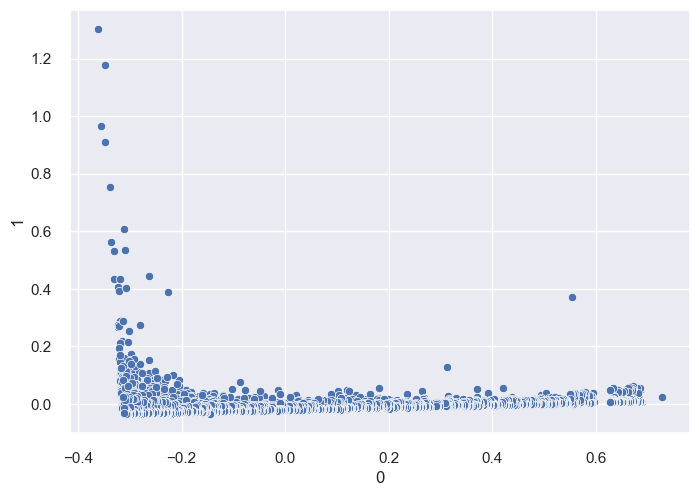

In [58]:
sns.scatterplot( x=0, y=1, data=df_pca);

### <font color=''> 4.3.2 UMPA </font>

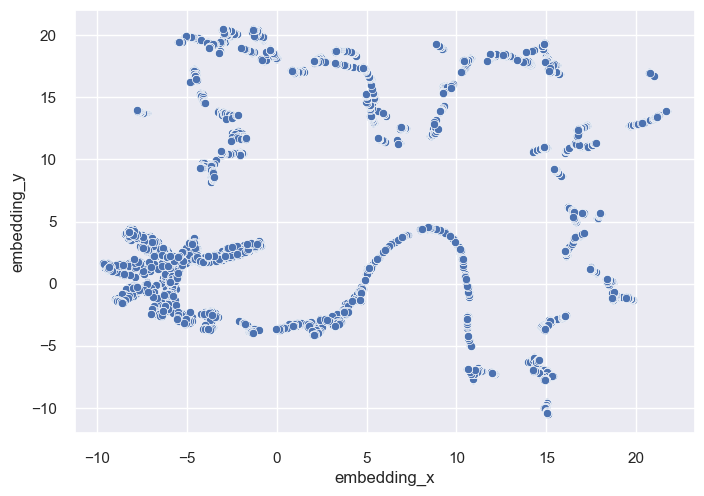

In [59]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                data=df_umap);

### <font color=''> 4.3.3 t-SNE </font>

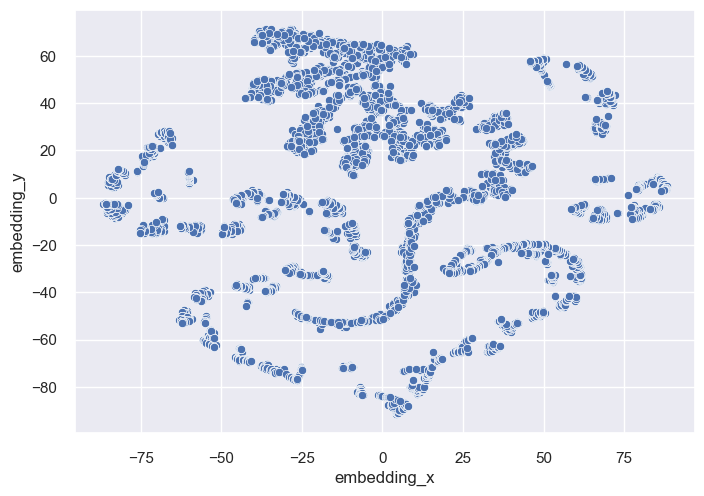

In [60]:
reducer = mf.TSNE(n_components=2, n_jobs=1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:,0]
df_tsne['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                data=df_tsne);

### <font color=''> 4.3.4 Tree-Based Embedding </font>

In [61]:
# training dataset
X = df43.drop(columns=['gross_revenue'], axis=1)
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42)

# model training
rf_model.fit( X,y )
pickle_dump(rf_model,'models','rf_model')
# save to S3
pickle.dump( rf_model, fs.open( 's3://insiders-dataset/rf_model.pkl','wb' ), protocol = pickle.HIGHEST_PROTOCOL )

# leaf
df_leaf = rf_model.apply( X )

# dataframe leaf
df_leaf = pd.DataFrame( df_leaf )


In [62]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6087,6545,6447,6425,6464,6449,6504,6467,6315,6570,...,6435,6370,6528,6289,6313,6453,6328,6424,6426,6691
1,6252,6488,6366,6397,6130,6413,6360,6090,6277,6305,...,6396,6307,5928,6267,6273,5847,6314,6355,6152,6288
2,6872,7000,6854,6770,6832,7022,6719,6908,6917,7012,...,6849,6978,6955,6906,6868,6870,6799,6833,6849,7064
3,3816,3925,3827,3807,3783,3842,3971,4135,4196,4078,...,4276,3871,3853,3760,3902,3474,4098,3651,3949,4187
4,1916,2118,1919,2017,1770,1269,2102,1280,1412,1417,...,2271,2079,2212,1449,1210,1803,2057,2087,3314,1442


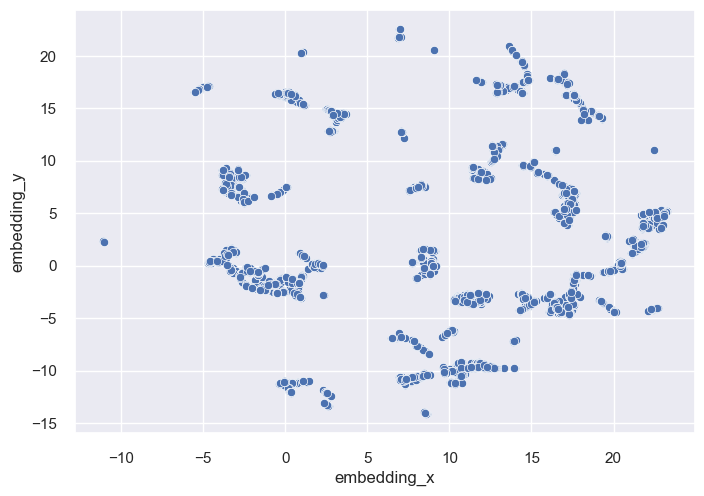

In [63]:
# Reducer dimensionality
reducer = umap.UMAP(random_state=42)

embedding = reducer.fit_transform(df_leaf)
pickle_dump(embedding,'features','embedding_umap_reducer')
# save to S3
pickle.dump( embedding, fs.open( 's3://insiders-dataset/embedding_umap_reducer.pkl','wb' ), protocol = pickle.HIGHEST_PROTOCOL )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                data=df_tree);

# <font color=''> 5.0 Data Preparation </font>

In [54]:
# Tree-Based Embedding
df5 = df_tree.copy()
df5.to_csv('../src/embeddings/tree_based_embedding.csv', index=False)

# # UMAP Embedding
# df5 = df_umap.copy()

# # TSNE Embedding
# df5 = df_tsne.copy()


# <font color=''> 7.0 Hyperparameter Fine-Tunning  </font>

In [169]:
X = df_tree.copy()

# X = df_umap.copy()

# X = df_tsne.copy()

clusters = np.arange(2,21,1)

## <font color=''> 7.1 K-Means </font>

In [140]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans_model = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean')
    kmeans_list.append( sil )

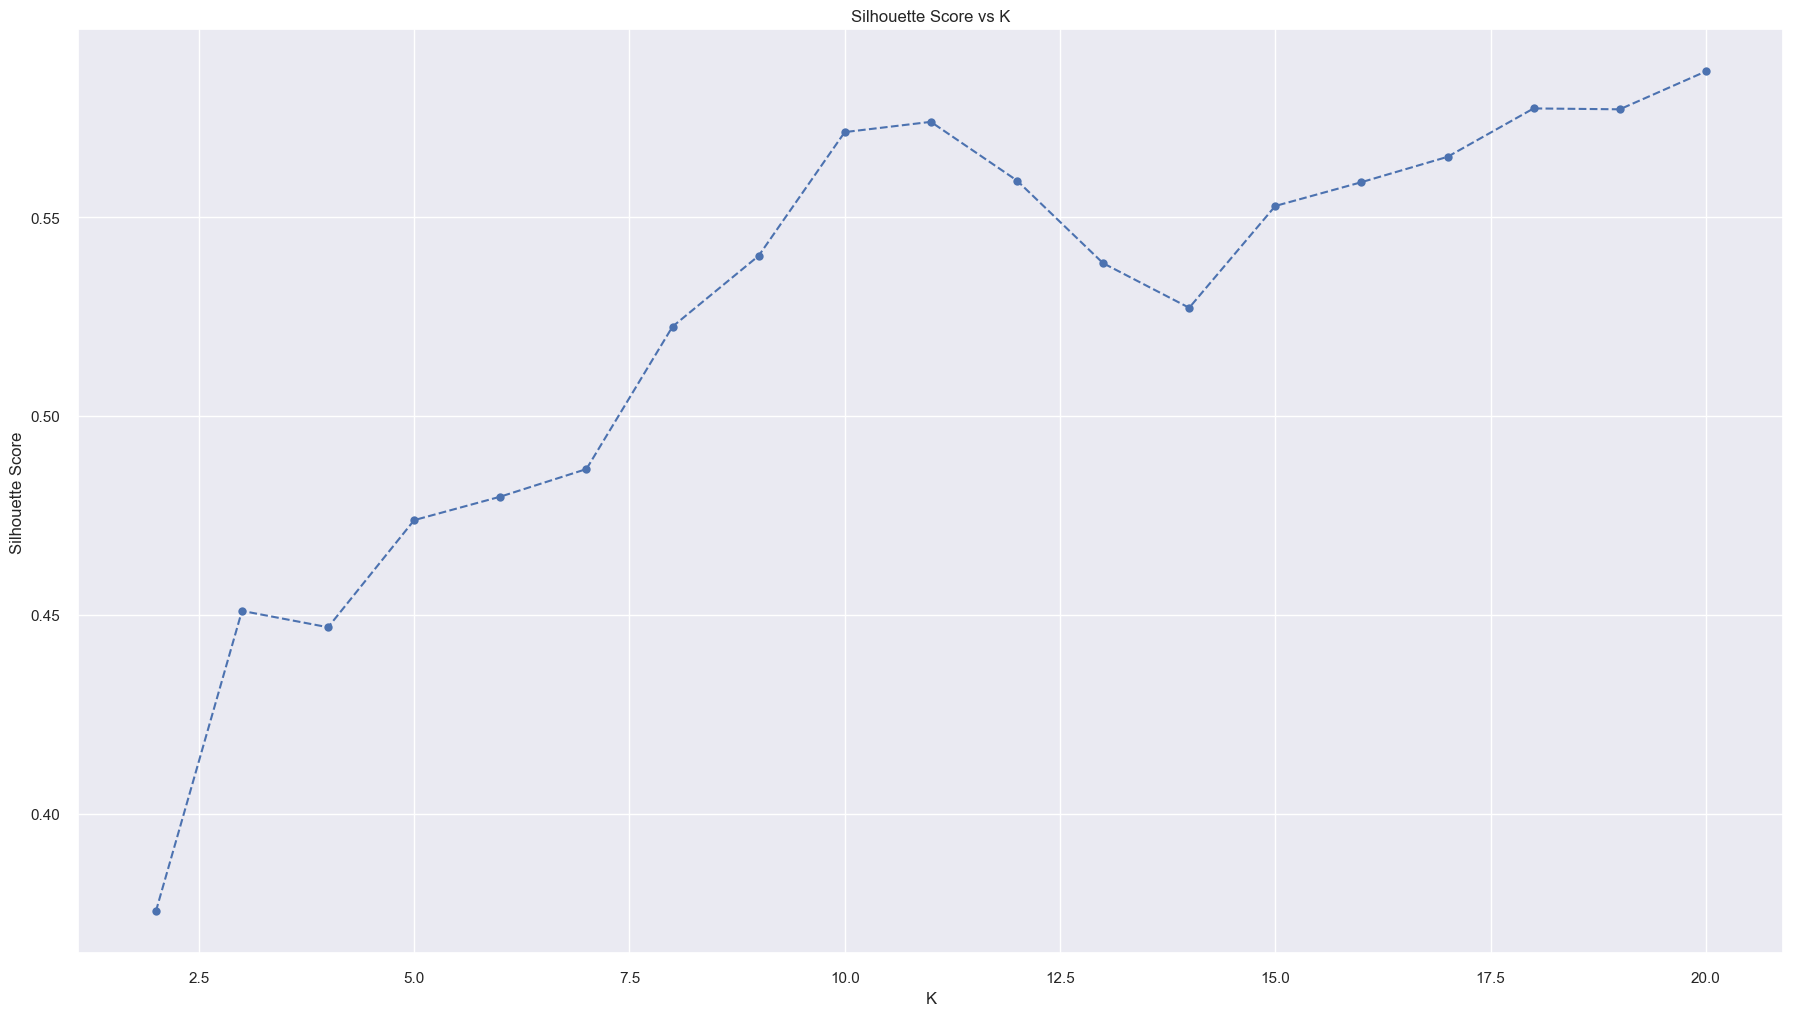

In [141]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b');
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title( 'Silhouette Score vs K');

## <font color=''> 7.2 GMM </font>

In [142]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k, n_init=100, random_state=42)

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean')
    gmm_list.append( sil )

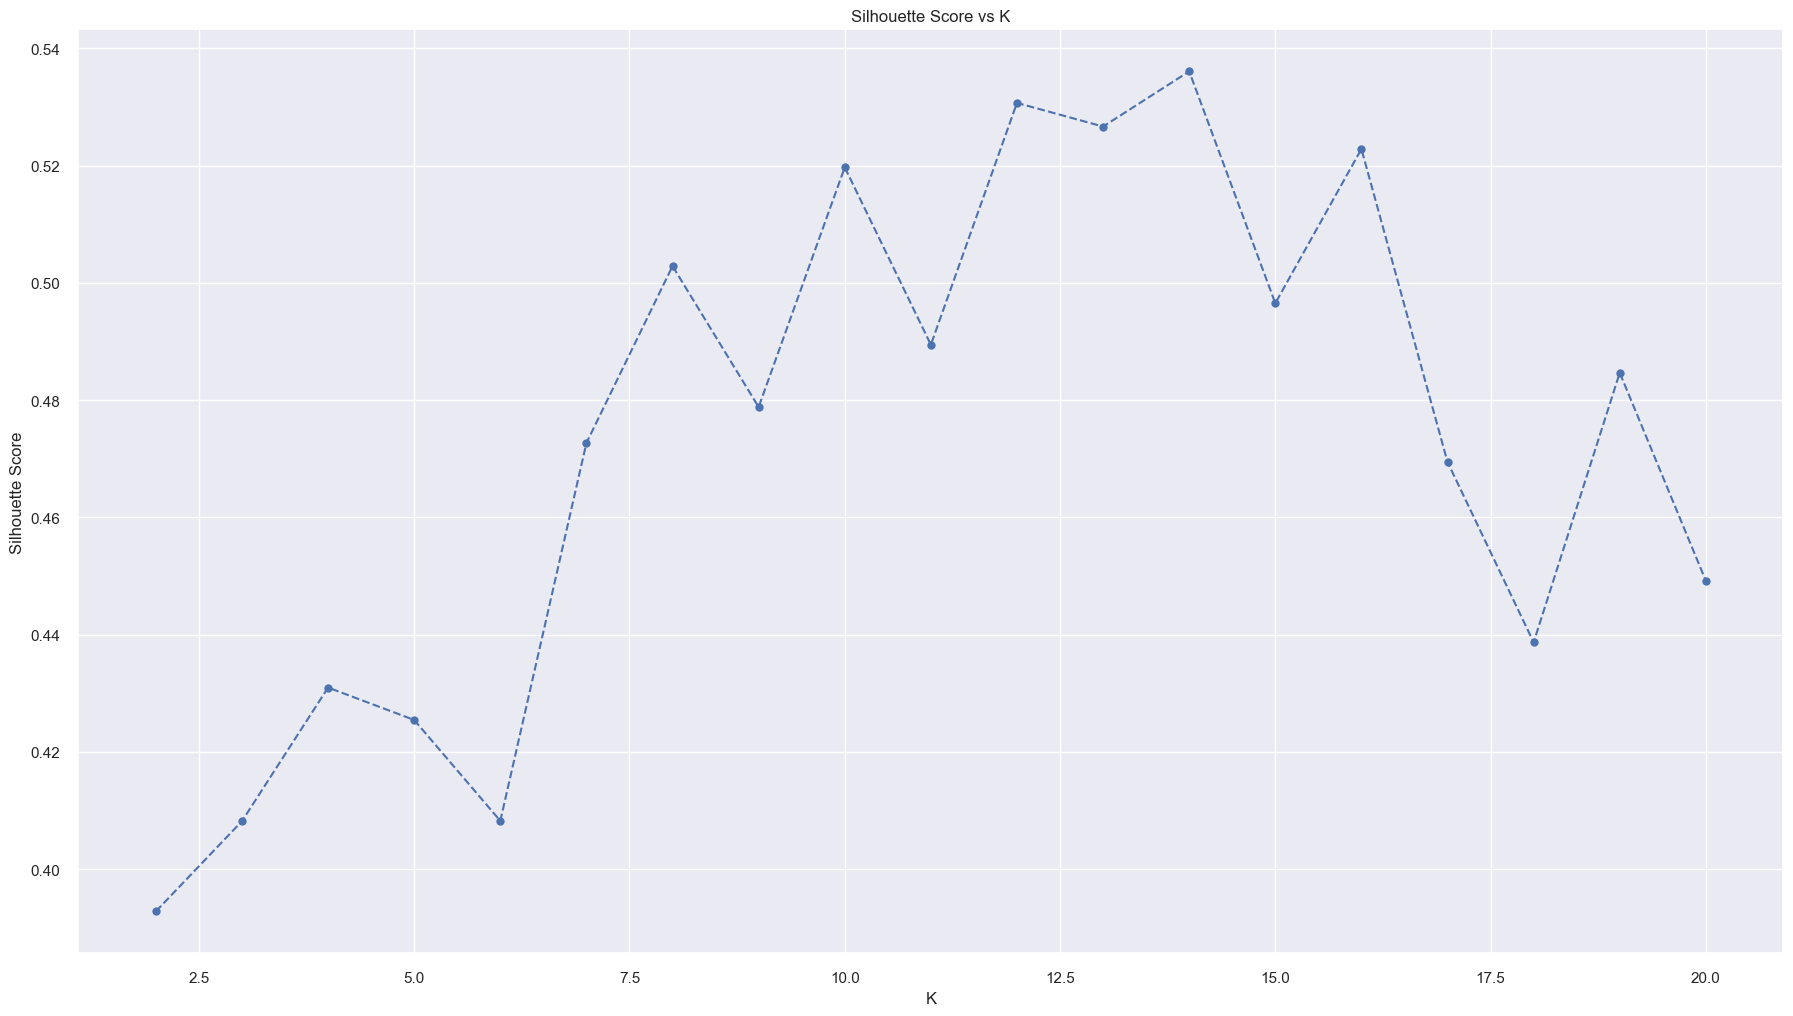

In [143]:
plt.plot( clusters, gmm_list, linestyle = '--', marker='o', color='b');
plt.xlabel ('K');
plt.ylabel ('Silhouette Score');
plt.title ('Silhouette Score vs K');

## <font color=''> 7.3 Hierarchical Clustering </font>

In [144]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward')

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean')
    hc_list.append( sil )

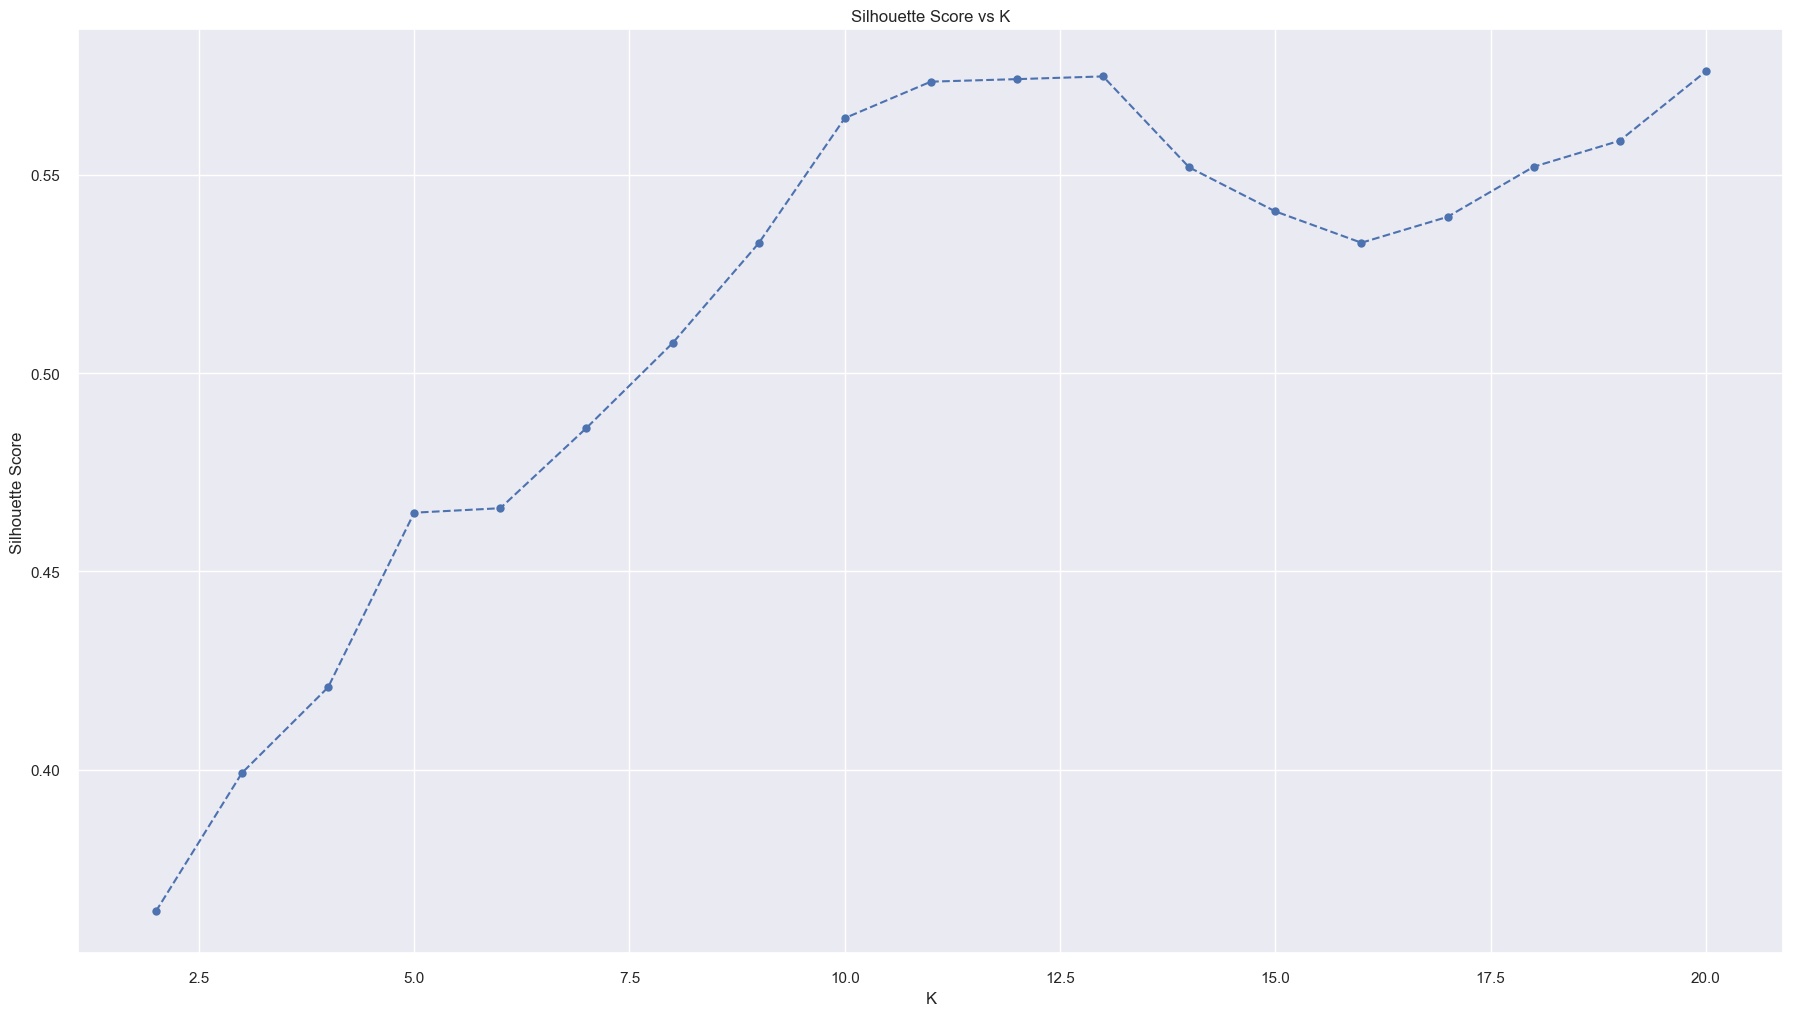

In [145]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b');
plt.xlabel ('K');
plt.ylabel ('Silhouette Score');
plt.title ('Silhouette Score vs K');

## <font color=''> 7.4 Results - Tree-based Embedding </font>

In [146]:
df_results = pd.DataFrame( 
    {'KMeans':kmeans_list, 
     'GMM':gmm_list, 
     'HClustering':hc_list,}
     ).T
df_results.columns = clusters

In [147]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
KMeans,0.375430,0.450999,0.446880,0.473817,0.479718,0.486659,0.522483,0.540284,0.571395,0.573972,0.559214,0.538428,0.527216,0.552816,0.558797,0.565176,0.577348,0.577124,0.586661
GMM,0.392791,0.408181,0.430967,0.425438,0.408232,0.472680,0.502847,0.478813,0.519691,0.489437,0.530679,0.526648,0.536056,0.496511,0.522819,0.469427,0.438681,0.484651,0.449164
HClustering,0.364233,0.399155,0.420755,0.464803,0.465932,0.486167,0.507563,0.532755,0.564324,0.573529,0.574166,0.574852,0.551907,0.540807,0.532898,0.539424,0.552058,0.558640,0.576119


## <font color=''> 7.5 Results - UMAP Embedding </font>

In [155]:
df_results = pd.DataFrame( 
    {'KMeans':kmeans_list, 
     'GMM':gmm_list, 
     'HClustering':hc_list,}
     ).T
df_results.columns = clusters

df_results.style.highlight_max(color='lightgreen', axis=1)

In [156]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
KMeans,0.423189,0.505666,0.518780,0.506831,0.509492,0.487704,0.518699,0.519292,0.526149,0.493558,0.508188,0.510027,0.512466,0.515572,0.516182,0.520651,0.503708,0.504090,0.532718
GMM,0.421863,0.460526,0.430364,0.412098,0.344789,0.342819,0.406641,0.401508,0.391296,0.422286,0.377329,0.428434,0.424982,0.427740,0.391217,0.414209,0.388138,0.330851,0.386044
HClustering,0.417680,0.468611,0.502507,0.502511,0.481087,0.491411,0.511157,0.503274,0.513549,0.473219,0.472514,0.472538,0.473221,0.489981,0.495499,0.503508,0.502746,0.497194,0.497409


## <font color=''> 7.6 Results - TSNE Embedding </font>

In [165]:
df_results = pd.DataFrame( 
    {'KMeans':kmeans_list, 
     'GMM':gmm_list, 
     'HClustering':hc_list,}
     ).T
df_results.columns = clusters

In [166]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
KMeans,0.365085,0.394887,0.415838,0.410731,0.400295,0.421006,0.421727,0.423973,0.440968,0.435885,0.435037,0.436535,0.446200,0.436519,0.432333,0.451175,0.459968,0.444537,0.459251
GMM,0.361684,0.387595,0.413737,0.358450,0.333601,0.218995,0.236349,0.235761,0.260525,0.248345,0.315358,0.294582,0.208748,0.313947,0.292081,0.294041,0.347139,0.372275,0.366568
HClustering,0.287410,0.360189,0.337941,0.330767,0.345979,0.360035,0.369681,0.388501,0.395902,0.388473,0.404486,0.419481,0.430306,0.426783,0.436030,0.431354,0.438677,0.437822,0.441783


## <font color=''> 7.5 Silhouette Analysis (SS)  </font>

IndexError: index 3 is out of bounds for axis 0 with size 3

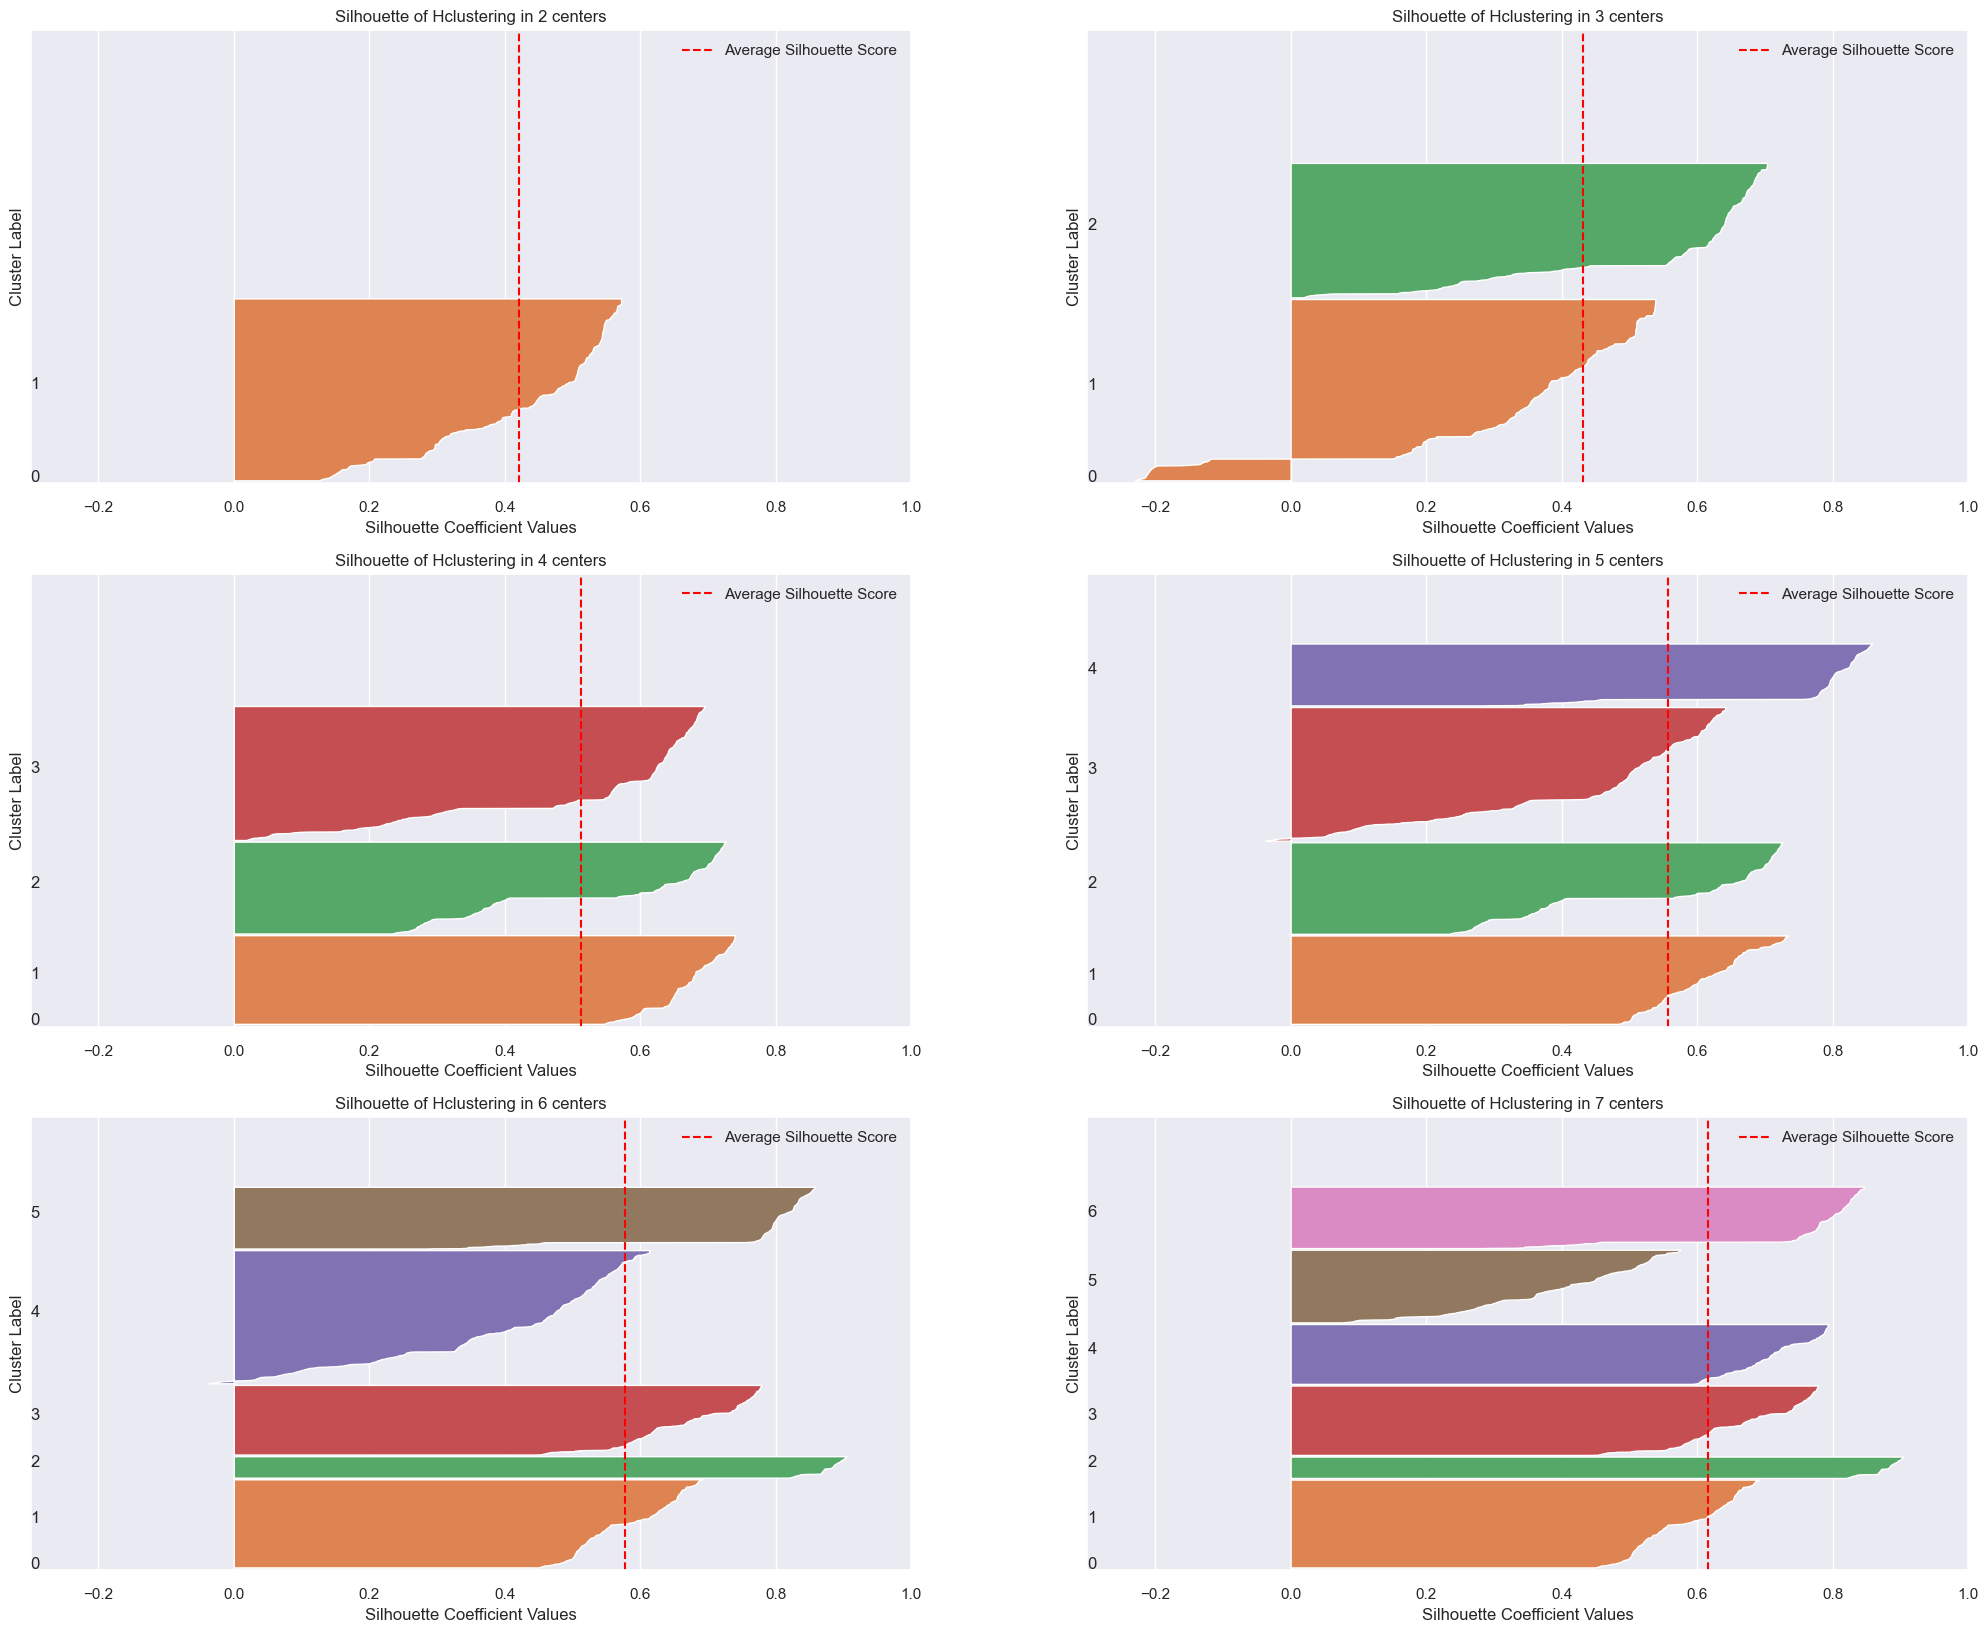

In [324]:
fig, ax = plt.subplots (3, 2)
fig.set_size_inches(25,20)


for k in clusters :
    q, mod = divmod( k, 2 )
    
    ax[q-1,mod].set_xlim( [-0.3,1] )
    ax[q-1,mod].set_ylim( [0,len( X ) + (k+1)*10] )
   
    
        
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean')

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):
     
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i] 

        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_clusters_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_clusters_i
        
        cmap = cm.get_cmap( 'Spectral')
        color = cmap( i/k )
        
        # plot
        ax[q-1, mod].fill_betweenx(np.arange( y_lower, y_upper), 0, ith_samples_silhouette_values);
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax[q-1,mod].text(-0.3, y_lower + 0.5 * size_clusters_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    
    ax[q-1,mod].set_xlabel ('Silhouette Coefficient Values');
    ax[q-1,mod].set_ylabel ('Cluster Label');
    ax[q-1,mod].set_title ('Silhouette of Hclustering in {} centers'.format(k));
    
    ax[q-1,mod].set_yticks([])  # Clear the yaxis labels / ticks
    
    # The vertical line for average silhouette score of all the values
    ax[q-1,mod].axvline(x=ss, color="red", linestyle="--", label = 'Average Silhouette Score')
    ax[q-1,mod].legend()
    

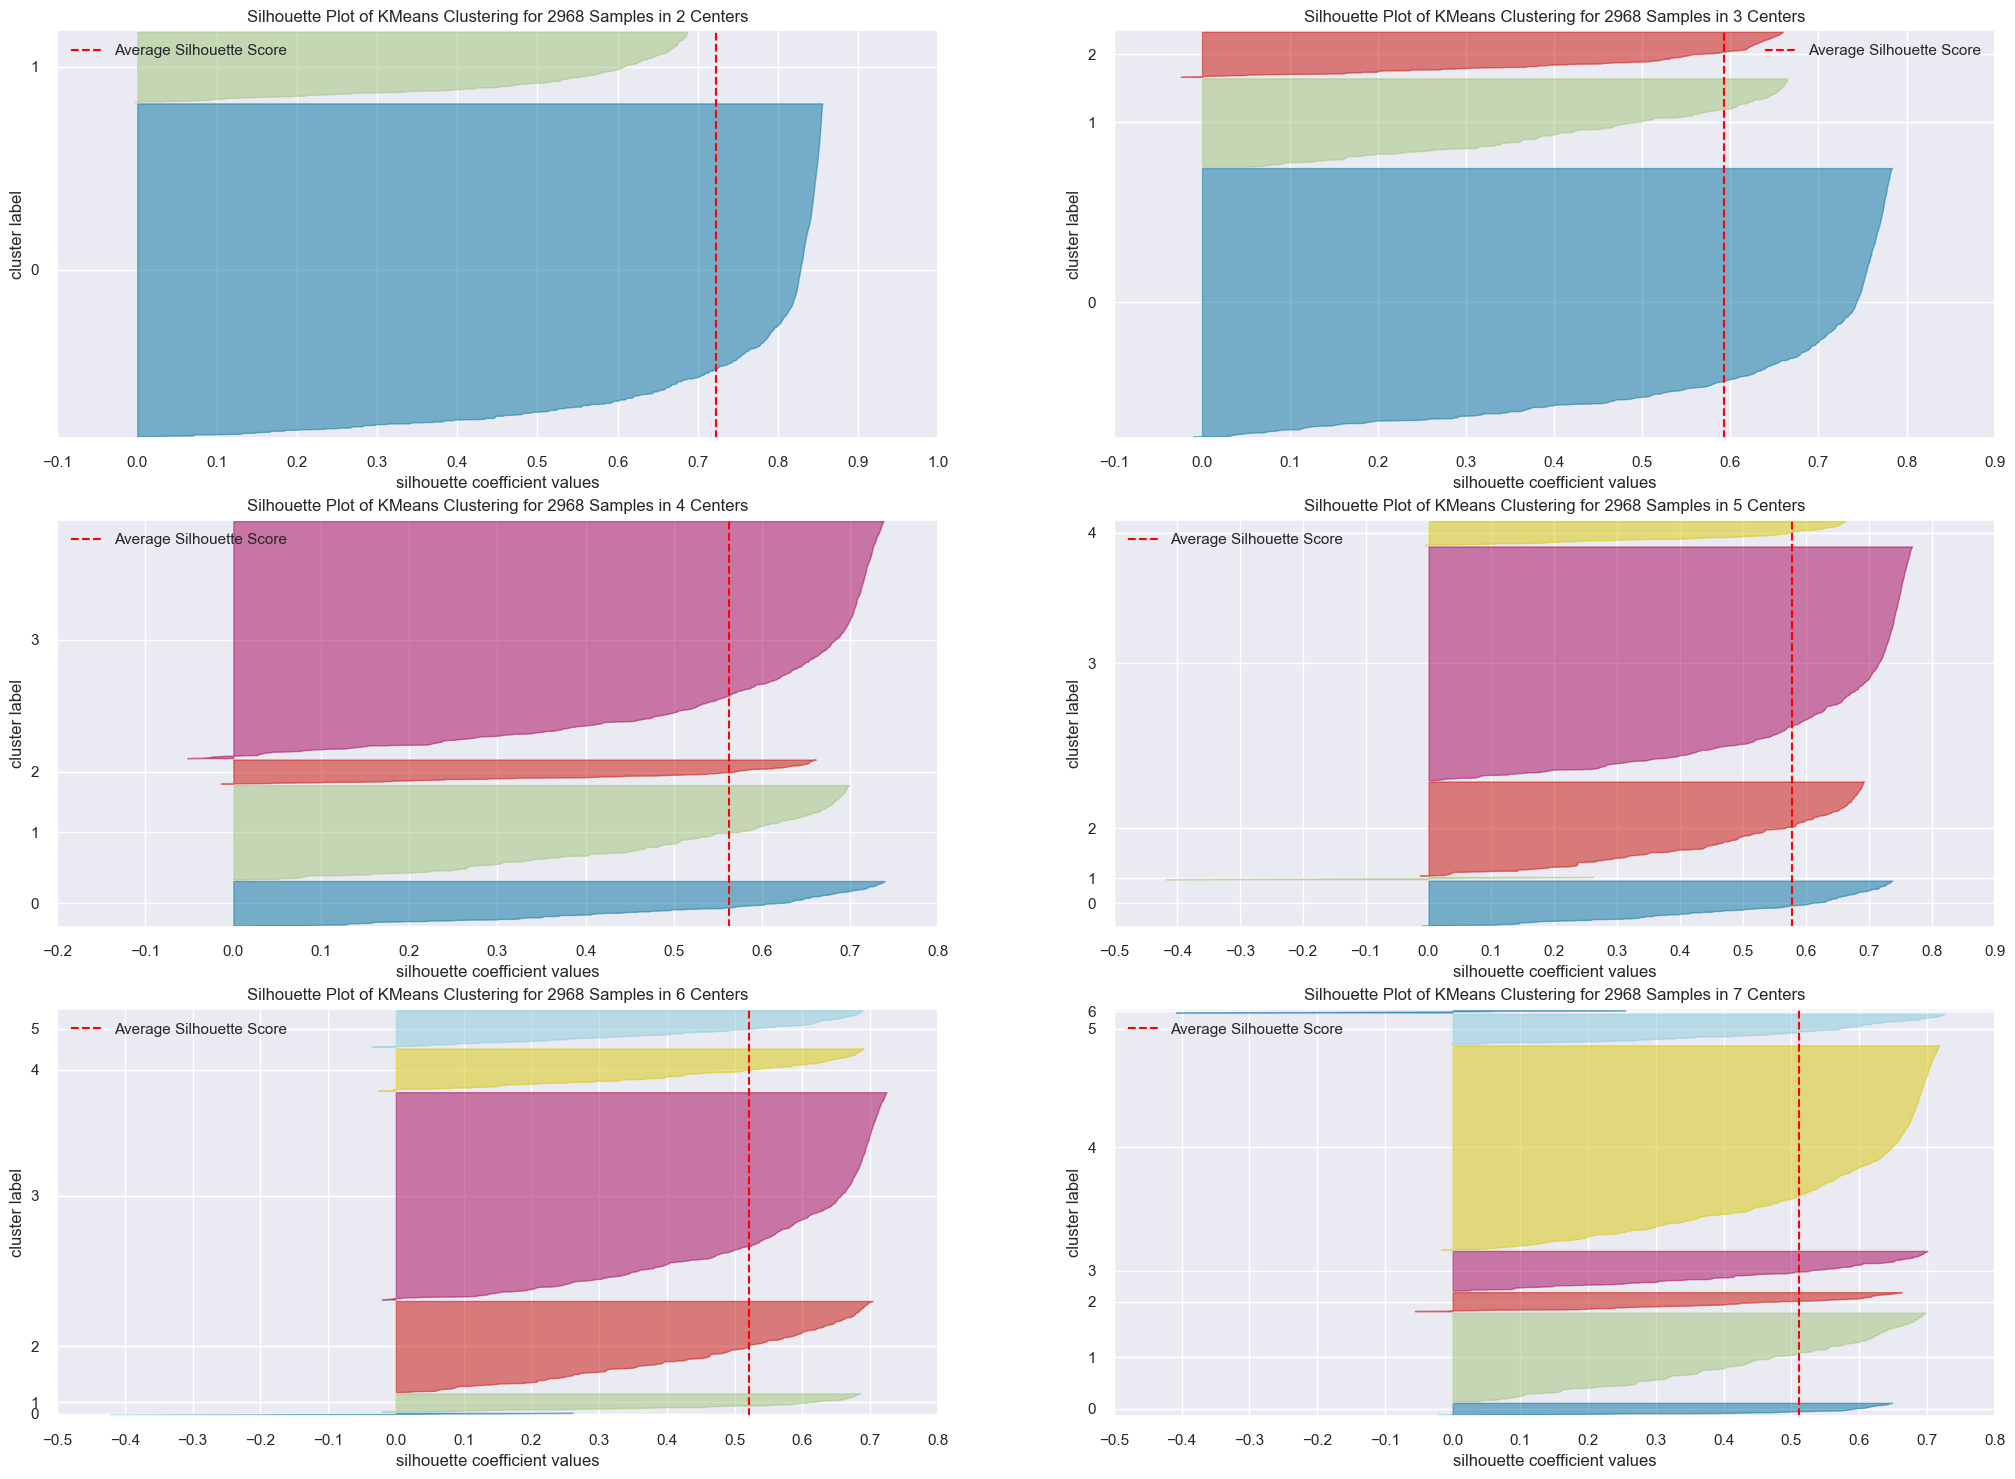

In [136]:
fig, ax = plt.subplots(3,2, figsize=(25,18))

for k in clusters:
    km=c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# <font color=''> 8.0 Model Training </font>

## <font color=''> 8.1 K-Means  </font>

In [38]:
X = pd.read_csv('../src/embeddings/tree_based_embedding.csv')

# model definition
k=10

# model definition
kmeans_model = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans_model.fit( X )

# model predict
labels = kmeans_model.predict( X )


## <font color=''> 8.2 Cluster Validation  </font>

In [39]:
# SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))


SS value: 0.5713945278879399


# <font color=''> 9.0 Cluster Analysis </font>

In [40]:
df9 = X.copy()

df9['cluster'] = labels
df4['cluster'] = labels

In [41]:
df9.head()

,embedding_x,embedding_y,cluster
0,-3.862080,8.698927,0
1,-3.597258,7.714051,0
2,-0.600013,16.399296,8
3,10.314145,-11.237587,3
4,17.093323,5.728156,7


## <font color=''> 9.1 Visualization Inspection  </font>

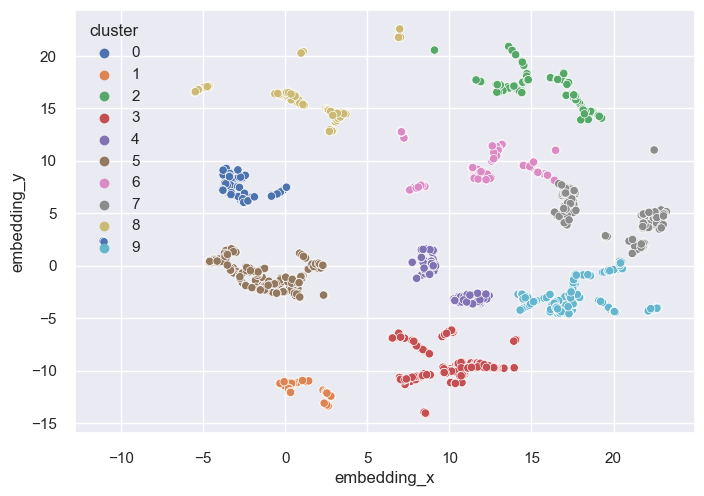

In [42]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

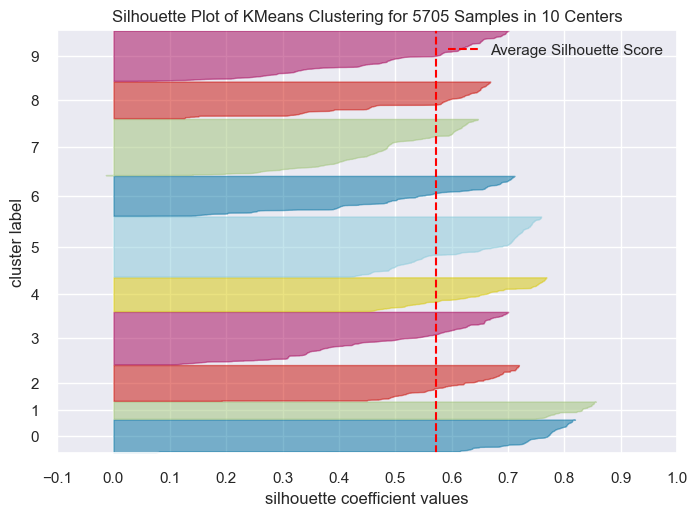

In [43]:
visualizer = SilhouetteVisualizer( kmeans_model, colors='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## <font color=''> 9.2 Cluster Profile  </font>

In [147]:
df92 = df4.copy()
df92['cluster'] = labels
df92.head()

# change dtypes
df92['recency_days'] = df92['recency_days'].astype(np.int64) 
df92['qtde_invoices'] = df92['qtde_invoices'].astype(np.int64) 
df92['qtde_items'] = df92['qtde_items'].astype(np.int64) 
df92['qtde_products'] = df92['qtde_products'].astype(np.int64) 
df92['qtde_returns'] = df92['qtde_returns'].astype(np.int64) 
df92['cluster'] = df92['cluster'].astype(np.int64) 

df92['last_training_timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')



In [148]:
# Number of customers
df_cluster = df92[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*df_cluster['customer_id']/df_cluster['customer_id'].sum()

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df92[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg items
df_qtde_products = df92[['qtde_items','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_products, how='inner', on='cluster')

# Frequency
df_frequency = df92[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Returns
df_returns = df92[['qtde_returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on='cluster').rename(columns={'customer_id':'num_customers'})


In [149]:
df_cluster.sort_values('gross_revenue',ascending=False)

,cluster,num_customers,perc_customer,gross_revenue,recency_days,qtde_items,frequency,qtde_returns
8,8,503,8.816827,5660.355109,51.502982,3405.898608,0.198810,54.304175
6,6,548,9.605609,4917.274690,174.642336,2823.702555,0.883861,218.850365
0,0,455,7.975460,2745.798264,61.676923,1506.593407,0.251544,18.375824
5,5,825,14.460999,1747.193952,67.787879,888.592727,0.251168,14.364848
1,1,237,4.154251,1135.208523,57.194093,486.881857,0.083720,8.578059
3,3,720,12.620508,1074.240347,118.979167,458.108333,0.570168,5.650000
4,4,464,8.133216,645.622328,115.685345,304.913793,0.528049,3.010776
9,9,689,12.077125,437.138316,132.348331,185.092888,0.648821,2.079826
7,7,772,13.531989,281.314663,158.158031,127.808290,0.786413,1.787565
2,2,492,8.624014,35.649533,193.658537,8.422764,0.992789,0.623984


# <font color=''> 10.0 EDA (Exploratory Data Analysis) </font>


In [150]:
df10 = df92.copy()

In [151]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns,cluster,last_training_timestamp
0,17850,5391.21,372,34,1733,297,18.152222,17.000000,40,0,2022-11-08 10:29:24
1,13047,3232.59,56,9,1390,171,18.904035,0.028302,35,0,2022-11-08 10:29:24
2,12583,6705.38,2,15,5028,232,28.902500,0.040323,50,8,2022-11-08 10:29:24
3,13748,948.25,95,5,439,28,33.866071,0.017921,0,3,2022-11-08 10:29:24
4,15100,876.00,333,3,80,3,292.000000,0.073171,22,7,2022-11-08 10:29:24


## <font color='black'> 10.2 Business Hyphoteses </font>


### <font color='black'> 10.2.1 Business Questions </font>


#### 1. Who are the people eligible to participate in the Loyals program?

In [152]:
df10.loc[df10['cluster'] == df_cluster.sort_values('gross_revenue',ascending=False)['cluster'].iloc[0],:].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns,cluster,last_training_timestamp
2,12583,6705.38,2,15,5028,232,28.902500,0.040323,50,8,2022-11-08 10:29:24
5,15291,4623.30,25,14,2102,102,45.326471,0.040115,29,8,2022-11-08 10:29:24
6,14688,5630.87,7,21,3621,327,17.219786,0.057221,399,8,2022-11-08 10:29:24
7,17809,5411.91,16,12,2057,61,88.719836,0.033520,41,8,2022-11-08 10:29:24
14,12431,6382.45,35,15,2899,233,27.392489,0.044248,50,8,2022-11-08 10:29:24


#### 2. How many customers will be part of the group?


In [153]:
df10.loc[df10['cluster'] == df_cluster.sort_values('gross_revenue',ascending=False)['cluster'].iloc[0],'customer_id'].size

503

#### 3. What are the main characteristics of these customers?


In [154]:
print('Number of Customers: {}'.format(df_cluster.sort_values('gross_revenue',ascending=False)['num_customers'].iloc[0]))

Number of Customers: 503


In [155]:
print('Average Revenue: {} €'.format(int(df_cluster.sort_values('gross_revenue',ascending=False)['gross_revenue'].iloc[0])))

Average Revenue: 5660 €


In [156]:
print('Average Recency: {} days'.format(int(df_cluster.sort_values('gross_revenue',ascending=False)['recency_days'].iloc[0])))

Average Recency: 51 days


In [157]:
print('Average of items purchased: {}'.format(int(df_cluster.sort_values('gross_revenue',ascending=False)['qtde_items'].iloc[0])))

Average of items purchased: 3405


In [158]:
print('Frequency of purchases: {} purchases/day'.format(round(df_cluster.sort_values('gross_revenue',ascending=False)['frequency'].iloc[0],2)))

Frequency of purchases: 0.2 purchases/day


#### 4. What is the percentage of revenue contribution from Loyals?


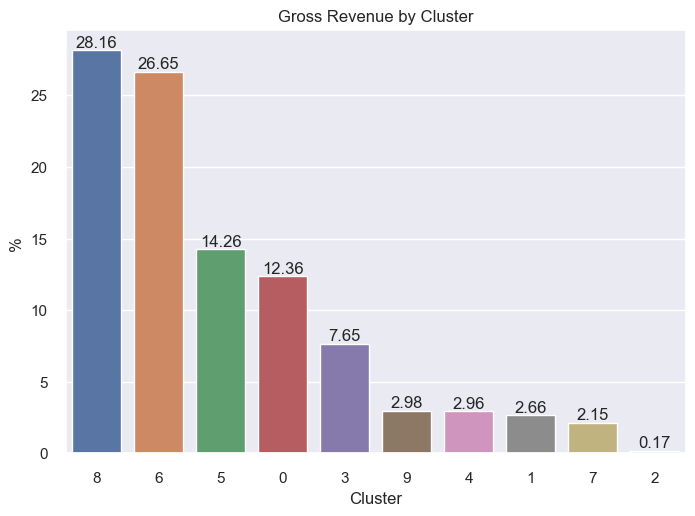

In [159]:
# group gross revenue by cluster 
df_revenue = df10[['cluster','gross_revenue']].groupby('cluster').sum().reset_index()

# calculate the percentage of gross revenue by cluster
df_revenue['%_gross_revenue'] = df_revenue['gross_revenue'].apply(lambda x: round(100*x/df_revenue['gross_revenue'].sum(),2))

# plot 
ax = sns.barplot(x='cluster',y='%_gross_revenue',data=df_revenue, order=df_revenue.sort_values('%_gross_revenue', ascending=False)['cluster']);
ax.set(ylabel='% ', title='Gross Revenue by Cluster', xlabel='Cluster');
ax.bar_label(ax.containers[0]);




In [160]:
df_insiders_gmv = df10.loc[df10['cluster']==df_cluster.sort_values('gross_revenue',ascending=False)['cluster'].iloc[0], 'gross_revenue'].sum()
df_all_gmv = df10.loc[:,'gross_revenue'].sum()

print( '% GMV from Insiders: {}'.format(100*df_insiders_gmv/df_all_gmv))

% GMV from Insiders: 28.16022593169225


#### 5. What are the conditions for a person to be eligible for Loyals?


The algorithm model will determine the customers who will be part of the loyals.

#### 6. What are the conditions for a person to be removed from Loyals?


"idem 5."

# <font color='black'> 11.0 Deploy to Production </font>

In [161]:
df92.dtypes

customer_id                  int64
gross_revenue              float64
recency_days                 int64
qtde_invoices                int64
qtde_items                   int64
qtde_products                int64
avg_ticket                 float64
frequency                  float64
qtde_returns                 int64
cluster                      int64
last_training_timestamp     object
dtype: object

## <font color='black'> 11.1 Insert into SQLITE </font>

In [165]:
# database connection
conn = create_engine ('sqlite:///insiders.sqlite')

# create table
query_create_table_insiders = """
    CREATE TABLE insiders (
        customer_id              INTEGER, 
        gross_revenue            REAL,   
        recency_days             INTEGER,  
        qtde_invoices            INTEGER,   
        qtde_items               INTEGER,
        qtde_products            INTEGER,   
        avg_ticket               REAL,
        frequency                REAL,
        qtde_returns             INTEGER,  
        cluster                  INTEGER,
        last_training_timestamp  TEXT
    )
"""
# conn.execute(query_create_table_insiders)


# drop table
# query_drop = """
#     DROP TABLE insiders
#  """
# conn.execute(query_drop)


# insert data
df92.to_sql('insiders', con=conn, if_exists='append', index=False)


5705

In [166]:
# consulting database
query = """
    SELECT * FROM insiders

"""

df = pd.read_sql_query(query,conn)

In [167]:
df.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns,cluster,last_training_timestamp
0,17850,5391.21,372,34,1733,297,18.152222,17.000000,40,0,2022-11-08 10:29:24
1,13047,3232.59,56,9,1390,171,18.904035,0.028302,35,0,2022-11-08 10:29:24
2,12583,6705.38,2,15,5028,232,28.902500,0.040323,50,8,2022-11-08 10:29:24
3,13748,948.25,95,5,439,28,33.866071,0.017921,0,3,2022-11-08 10:29:24
4,15100,876.00,333,3,80,3,292.000000,0.073171,22,7,2022-11-08 10:29:24
